In [1]:
!pip install requests librosa scipy numpy biopython scikit-learn fastdtw faiss-cpu


In [2]:
import os
import urllib.request
import tarfile
import numpy as np
import pickle

def download_sift1m(url, local_tar):
    urllib.request.urlretrieve(url, local_tar)
    return local_tar

def extract_tar(file, extract_to):
    with tarfile.open(file, 'r:gz') as tar_ref:
        tar_ref.extractall(extract_to)

def load_sift_data(file):
    with open(file, 'rb') as f:
        # Note: .fvecs format used in SIFT1M has a specific structure. Each vector has 129 features.
        num_features = 129
        sift_vectors = np.fromfile(f, dtype=np.float32)
        sift_vectors = sift_vectors.reshape(-1, num_features)
        return sift_vectors

def convert_sift_to_sequences(sift_vectors, feature_size=3, sequence_length=43):
    num_sequences = sift_vectors.shape[0]
    sequences = np.zeros((num_sequences, sequence_length, feature_size), dtype=np.float16)
    for i in range(num_sequences):
        vector = sift_vectors[i, :feature_size * sequence_length]
        sequences[i] = vector.reshape(sequence_length, feature_size)
    return sequences

def preprocess_sequences(sequences):
    num_sequences = sequences.shape[0]
    flattened_sequences = sequences.reshape(num_sequences, -1)
    return flattened_sequences

if __name__ == "__main__":
    # URL for the SIFT1M dataset
    dataset_url = "ftp://ftp.irisa.fr/local/texmex/corpus/sift.tar.gz"
    local_tar = "sift.tar.gz"
    extract_to = "sift1m"

    # Download the dataset
    print(f"Downloading dataset from {dataset_url}...")
    try:
        download_sift1m(dataset_url, local_tar)
        print("Download complete.")

        # Extract the dataset
        print(f"Extracting dataset to {extract_to}...")
        extract_tar(local_tar, extract_to)
        print("Extraction complete.")
    except Exception as e:
        print(f"Failed to download or extract the dataset: {e}")
        exit(1)

    # Load SIFT vectors
    print("Loading SIFT vectors...")
    sift_vectors = load_sift_data(os.path.join(extract_to, "sift/sift_base.fvecs"))
    print(f"Loaded {sift_vectors.shape[0]} SIFT vectors.")

    # Convert SIFT vectors to sequences
    print("Converting SIFT vectors to sequences...")
    sequences = convert_sift_to_sequences(sift_vectors, feature_size=3, sequence_length=43)
    print("Conversion complete.")

    # Preprocess sequences for benchmarking
    print("Preprocessing sequences...")
    preprocessed_sequences = preprocess_sequences(sequences)
    with open('preprocessed_sequences.pkl', 'wb') as f:
        pickle.dump(preprocessed_sequences, f)  # Save the preprocessed sequences to a pickle file
    print("Preprocessing complete.")
    print("Sequences saved to preprocessed_sequences.pkl")


Download complete.
Extracting dataset to sift1m...
Extraction complete.
Loading SIFT vectors...
Loaded 1000000 SIFT vectors.
Converting SIFT vectors to sequences...
Conversion complete.
Preprocessing sequences...
Preprocessing complete.
Sequences saved to preprocessed_sequences.pkl


In [3]:
import numpy as np
import time
import pickle
from Bio.Align import PairwiseAligner
from fastdtw import fastdtw
import faiss
import seaborn as sns
import matplotlib.pyplot as plt
# import faiss.contrib.torch_utils  # Ensures that the FAISS GPU library is available

class FastSeqSearch:
    def __init__(self, sequences):
        self.sequences = sequences
        self.index = self.build_index(sequences)

    def build_index(self, sequences):
        d = sequences.shape[1]  # Dimensionality of the preprocessed sequence
        index = faiss.IndexHNSWFlat(d, 32)  # HNSW index with 32 neighbors
        index.hnsw.efConstruction = 40
        index.add(sequences)
        return index

    def search(self, query, k=1000):
        query_vector = query.flatten().astype(np.float32).reshape(1, -1)
        D, I = self.index.search(query_vector, k)
        return I[0]

    def refine_search(self, query, candidates):
        refined_candidates = []
        for idx in candidates:
            candidate_seq = self.sequences[idx].reshape(43, 3)
            dist, _ = fastdtw(query.reshape(43, 3), candidate_seq)
            refined_candidates.append((idx, dist))
        refined_candidates.sort(key=lambda x: x[1])
        return refined_candidates

def benchmark_dtw_search(query_seq, sequences):
    distances = []
    start_time = time.time()
    for seq in sequences:
        dist, _ = fastdtw(query_seq, seq.reshape(43, 3))
        distances.append(dist)
    end_time = time.time()
    total_time = end_time - start_time
    min_distance = min(distances)
    print(f"DTW: Total time taken: {total_time:.6f} seconds, Min distance: {min_distance}")
    return total_time, min_distance

def benchmark_fastdtw_search(query_seq, sequences):
    distances = []
    start_time = time.time()
    for seq in sequences:
        dist, _ = fastdtw(query_seq, seq.reshape(43, 3))
        distances.append(dist)
    end_time = time.time()
    total_time = end_time - start_time
    min_distance = min(distances)
    print(f"FastDTW: Total time taken: {total_time:.6f} seconds, Min distance: {min_distance}")
    return total_time, min_distance

def benchmark_smith_waterman_search(query_seq, sequences):
    aligner = PairwiseAligner()
    query_seq_str = ''.join(map(chr, query_seq.flatten().astype(int) % 256))
    distances = []
    start_time = time.time()
    for seq in sequences:
        seq_str = ''.join(map(chr, seq.reshape(43, 3).flatten().astype(int) % 256))
        alignment = aligner.align(query_seq_str, seq_str)
        dist = alignment.score  # Using score as distance
        distances.append(dist)
    end_time = time.time()
    total_time = end_time - start_time
    max_distance = max(distances)  # Higher score means closer match
    print(f"Smith-Waterman: Total time taken: {total_time:.6f} seconds, Max score (closest distance): {max_distance}")
    return total_time, max_distance

def benchmark_fastseqsearch(query_seq, sequences, k=1000):
    fastseqsearch = FastSeqSearch(sequences)
    start_time = time.time()
    candidates = fastseqsearch.search(query_seq, k)
    refined_candidates = fastseqsearch.refine_search(query_seq, candidates)
    end_time = time.time()
    total_time = end_time - start_time
    min_distance = refined_candidates[0][1]  # The closest distance after refinement
    print(f"FastSeqSearch: Total time taken: {total_time:.6f} seconds, Min distance: {min_distance}")
    return total_time, min_distance

def plot_benchmarks(results):
    # Sorting the results for better visualization
    sorted_results = sorted(results.items(), key=lambda x: x[1])

    # Extracting methods and their times
    methods = [item[0] for item in sorted_results]
    times = [item[1] for item in sorted_results]

    # Setting the style and color palette
    sns.set(style="whitegrid")
    palette = sns.color_palette("viridis", len(methods))

    # Plotting
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x=times, y=methods, palette=palette)

    # Adding titles and labels
    plt.title("Benchmarking Sequence Search Methods", fontsize=16, fontweight='bold')
    plt.xlabel("Time (seconds)", fontsize=14)
    plt.ylabel("Methods", fontsize=14)

    # Annotating the times on the bars
    for i, v in enumerate(times):
        ax.text(v + 0.2, i, f"{v:.6f} s", color='black', va='center', fontsize=12)

    # Adding grid lines
    ax.xaxis.grid(True)
    ax.yaxis.grid(False)

    # Setting font properties
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.show()

if __name__ == "__main__":
    # Load the preprocessed sequences
    with open('preprocessed_sequences.pkl', 'rb') as f:
        preprocessed_sequences = pickle.load(f)

    preprocessed_sequences = preprocessed_sequences.astype(np.float32)
    # Use the first sequence as the query sequence
    query_seq = preprocessed_sequences[0].reshape(43, 3)

    # Benchmark different search methods
    results = {}

    print("Benchmarking FastSeqSearch...")
    total_time, _ = benchmark_fastseqsearch(query_seq, preprocessed_sequences[:], k=1000)
    results["FastSeqSearch"] = total_time

    print("Benchmarking DTW search...")
    total_time, _ = benchmark_dtw_search(query_seq, preprocessed_sequences[:])
    results["DTW"] = total_time

    print("Benchmarking FastDTW search...")
    total_time, _ = benchmark_fastdtw_search(query_seq, preprocessed_sequences[:])
    results["FastDTW"] = total_time

    print("Benchmarking Smith-Waterman search...")
    total_time, _ = benchmark_smith_waterman_search(query_seq, preprocessed_sequences[:])
    results["Smith-Waterman"] = total_time


Benchmarking FastSeqSearch...
FastSeqSearch: Total time taken: 0.215453 seconds, Min distance: 0.0
Benchmarking DTW search...
DTW: Total time taken: 227.630538 seconds, Min distance: 0.0
Benchmarking FastDTW search...
FastDTW: Total time taken: 222.614665 seconds, Min distance: 0.0
Benchmarking Smith-Waterman search...
Smith-Waterman: Total time taken: 216.031538 seconds, Max score (closest distance): 129.0


<ipython-input-4-31b59ff07c20>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=inverted_times, y=methods, palette=palette)


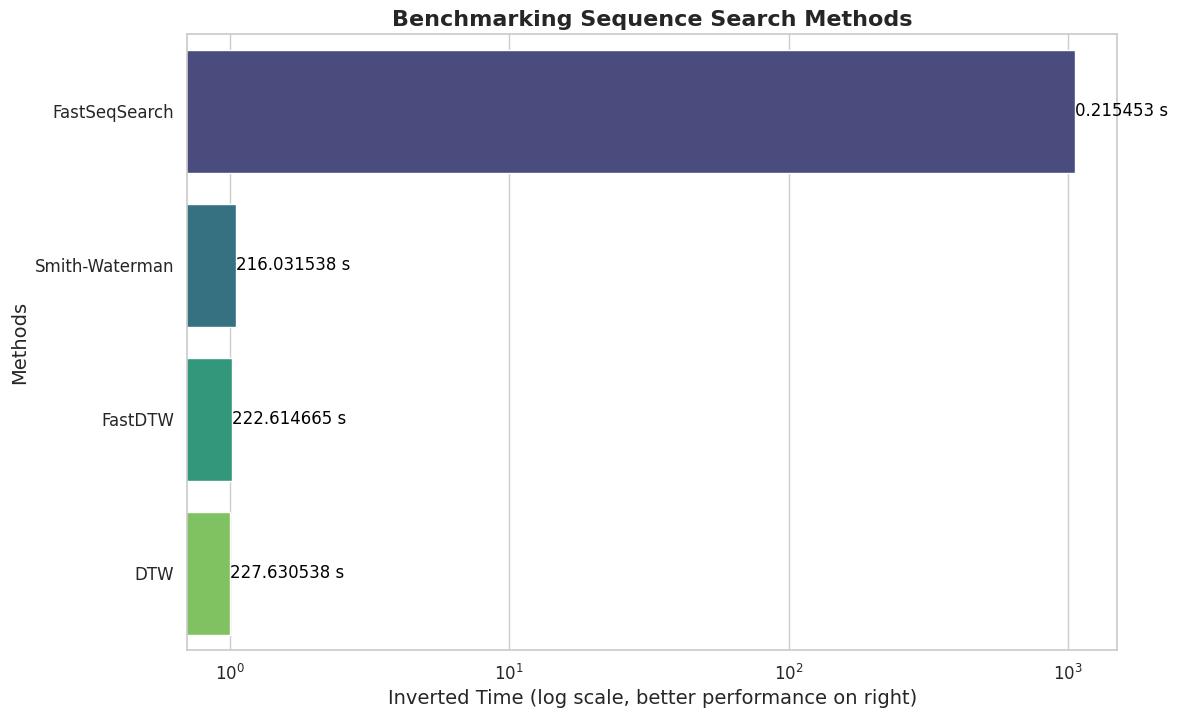

In [4]:
def plot_benchmarks(results):
    # Sorting the results for better visualization
    sorted_results = sorted(results.items(), key=lambda x: x[1])

    # Extracting methods and their times
    methods = [item[0] for item in sorted_results]
    times = [item[1] for item in sorted_results]

    # Invert the values for plotting (lower is better)
    max_time = max(times)
    inverted_times = [max_time / t for t in times]

    # Setting the style and color palette
    sns.set(style="whitegrid")
    palette = sns.color_palette("viridis", len(methods))

    # Plotting with logarithmic scale
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x=inverted_times, y=methods, palette=palette)
    ax.set_xscale("log")

    # Adding titles and labels
    plt.title("Benchmarking Sequence Search Methods", fontsize=16, fontweight='bold')
    plt.xlabel("Inverted Time (log scale, better performance on right)", fontsize=14)
    plt.ylabel("Methods", fontsize=14)

    # Annotating the times on the bars
    for i, v in enumerate(times):
        ax.text(inverted_times[i], i, f"{v:.6f} s", color='black', va='center', fontsize=12)

    # Adding grid lines
    ax.xaxis.grid(True)
    ax.yaxis.grid(False)

    # Setting font properties
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.show()
# Plot the benchmark results
plot_benchmarks(results)